In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
#pip install pandas-datareader

stock = 'CIEL3.SA'
source = 'yahoo'

# Set date range (Google went public August 19, 2004)
start = datetime.datetime(2004, 8, 19)
end = datetime.datetime(2019, 7, 19)

# Collect Google stock data
goog_df = data.DataReader(stock, source, start, end)

dataset = goog_df['Adj Close']

goog_df['Adj Close'].plot(kind='line', grid=True, title='GOOG Adjusted Closes, IPO through 2016')
print(len(dataset))

2481


In [2]:
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot

tf.set_random_seed(666)
dataset = np.array(dataset.astype('float32'))


#autocorrelation_plot(dataset)

corr=[]
for i in range(0,len(dataset)):
    #print(i,pd.Series(dataset.T[0]).autocorr(lag=i))
    corr.append(pd.Series(dataset.T).autocorr(lag=i))

janela=(np.where(corr[1:-2]==np.max(corr[1:-2]))[0]+1)[0]
    
X0=dataset[0:-12]
Y0=dataset[-12:]
X0

W0721 00:58:27.801166 139948233254656 module_wrapper.py:136] From /home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

/home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


array([2.948277 , 2.9623427, 3.1346328, ..., 6.72     , 6.68     ,
       6.55     ], dtype=float32)

In [3]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series)
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

tf.reset_default_graph()
series_model = build_model(X0)

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      series_model,
      observed_time_series=X0)
  
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

train_vi = tf.train.AdamOptimizer(0.07).minimize(elbo_loss)



W0721 00:58:31.133609 139948233254656 linear_operator.py:942] Using (possibly slow) default implementation of to_dense.  Converts by self.matmul(identity).
W0721 00:58:31.252691 139948233254656 deprecation.py:506] From /home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0721 00:58:33.610044 139948233254656 module_wrapper.py:136] From /home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0721 00:58:35.084368 139948233254656 deprecation.py:323] From /home/rubensvectomobile_gmail_com/.local/lib/python3.5/site-pac

In [4]:
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.4
#conf.gpu_options.allocator_type = 'BFC'
conf.gpu_options.allow_growth = False
conf.allow_soft_placement = True

In [5]:
with tf.Session(config=conf) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_variational_steps):
        _, elbo_ = sess.run((train_vi, elbo_loss))
        if i % 20 == 0:
            print("step {} -ELBO {}".format(i, elbo_))
    # Draw samples from the variational posterior.
    samples = sess.run({k: q.sample(50) for k, q in variational_posteriors.items()})


step 0 -ELBO 8834.779296875
step 20 -ELBO 6153.666015625
step 40 -ELBO 2906.33740234375
step 60 -ELBO 1252.687744140625
step 80 -ELBO 997.95556640625
step 100 -ELBO 783.8032836914062
step 120 -ELBO 686.794189453125
step 140 -ELBO 621.3990478515625
step 160 -ELBO 567.53173828125
step 180 -ELBO 539.9827880859375


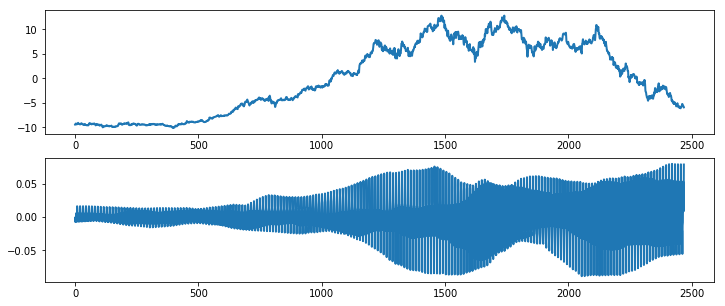

In [6]:
component_dists = sts.decompose_by_component(
    series_model,
    observed_time_series=X0,
    parameter_samples=samples)


with tf.Session() as sess:
  series_component_means_, series_component_stddevs_ = sess.run(
      [{k.name: c.mean() for k, c in component_dists.items()},
       {k.name: c.stddev() for k, c in component_dists.items()}])

component_means_dict=series_component_means_ 
component_stddevs_dict=series_component_stddevs_
    
import collections

axes_dict = collections.OrderedDict()
num_components = len(component_means_dict)
fig = plt.figure(figsize=(12, 2.5 * num_components))
for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(np.arange(0,len(X0)), component_mean,lw=2)    



150


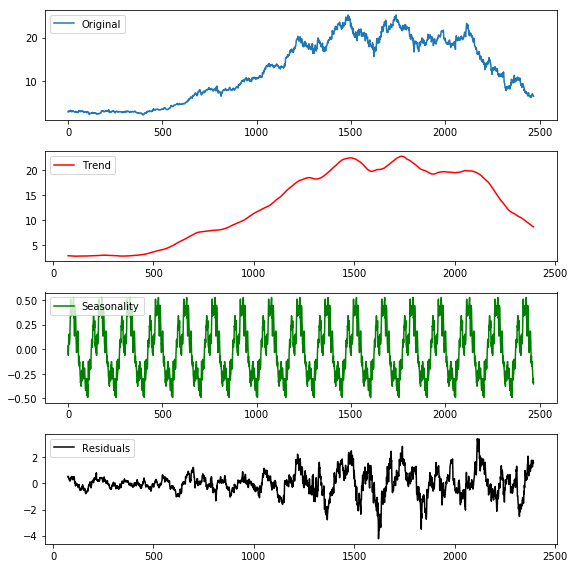

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(X0,freq=150)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

z=np.where(seasonal==min(seasonal))[0]
period=z[2]-z[1]
print(period)

plt.figure(figsize=(8,8))
plt.subplot(411)
plt.plot(X0, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend',color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality',color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals',color='black')
plt.legend(loc='upper left')
plt.tight_layout()




Inferred parameters:
observation_noise_scale: 0.050185900181531906 +- 0.004571469966322184
LocalLinearTrend/_level_scale: 0.2622007131576538 +- 0.005358982365578413
LocalLinearTrend/_slope_scale: 0.02909049019217491 +- 0.0007699574343860149
Seasonal/_drift_scale: 0.012758119963109493 +- 0.00066870212322101


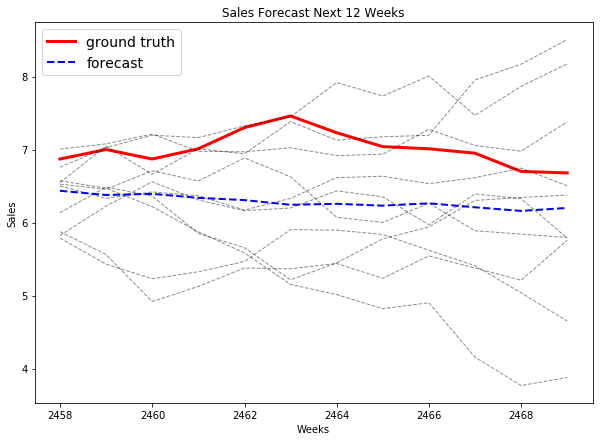

R2 -10.91048429492409


In [14]:
print("Inferred parameters:")
for param in series_model.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(samples[param.name], axis=0),
                              np.std(samples[param.name], axis=0)))
    
num_forecast_steps=12
series_forecast_dist = tfp.sts.forecast(
    series_model,
    observed_time_series=X0,
    parameter_samples=samples,
    num_steps_forecast=num_forecast_steps)

series_forecast_dist

num_samples=10

with tf.Session() as sess:
  series_forecast_mean, series_forecast_scale, series_forecast_samples = sess.run(
      (series_forecast_dist.mean()[..., 0],
       series_forecast_dist.stddev()[..., 0],
       series_forecast_dist.sample(num_samples)[..., 0]))

x=np.linspace(0,len(X0),len(X0))
num_steps = len(X0)
num_steps_forecast = series_forecast_mean.shape[-1]
num_steps_train = num_steps - num_steps_forecast
forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

plt.figure(figsize=(10,7))
plt.plot(forecast_steps,Y0,color='red',label='ground truth',lw=3)
plt.plot(forecast_steps, series_forecast_samples.T, lw=1,ls='--',color='black', alpha=0.45)
plt.plot(forecast_steps, series_forecast_mean, lw=2, ls='--', color='blue',label='forecast')
plt.legend(loc=2,prop={'size': 14})
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.title('Sales Forecast Next 12 Weeks')
plt.show()


from sklearn.metrics import r2_score
print('R2',r2_score(Y0,series_forecast_mean))